# Comparison between learning sensorimotor models 
## Part 1 : non parametric models

In this notebook, we compare the different sensorimotor models used in explauto in order to help the reader to use the most appropriate model depending on his aim. The notebook is split in two parts : non parametrics models (this notebook) and models based on gaussian mixtures (coming soon). There is also a tutorial explaining how to use the [SensorimotorModel abstract class](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html#explauto.sensorimotor_model.sensorimotor_model.SensorimotorModel) ([learning_sensorimotor_models](http://nbviewer.ipython.org/github/flowersteam/explauto/blob/master/notebook/learning_sensorimotor_models.ipynb)).

As explained in the [Explauto introduction](http://flowersteam.github.io/explauto/about.html), an important challenge in Developmental Robotics is how robots can efficiently learn sensorimotor mappings by experience, i.e. the mappings between the motor actions they make and the sensory effects they produce. This can be a robot learning how arm movements make physical objects move, or how movements of a virtual vocal tract modulates vocalization sounds.

Let's begin with defining a simple environment that will be used to test the sensorimotor models.

In [1]:
from explauto import Environment
environment = Environment.from_configuration('simple_arm', 'low_dimensional')

### Sensorimotor models introduction

In Explauto, a sensorimotor model implements both the iterative learning process from sensorimotor experience, i.e. from the iterative collection of $(m, s)$ pairs by interaction with the environment, and the use of the resulting internal model to perform forward and inverse predictions (or any kind of general prediction between sensorimotor subspaces). 

Learning sensorimotor mappings involves machine learning algorithms, for which Explauto provides a unified interface through the [SensorimotorModel abstract class](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html#explauto.sensorimotor_model.sensorimotor_model.SensorimotorModel). 

Using the simple arm environment above, it allows to iteratively learn a sensorimotor model which will be able to:
* infer the position of the end-effector from a given motor command, what is called *forward prediction*,
* infer the motor command allowing to reach a particular end-effector position, what is called *inverse prediction*.
* update online from sensorimotor experience

In [23]:
from scipy import spatial
import numpy as np
import time

#Environment definition
from explauto.environment.environment import Environment
environment = Environment.from_configuration('simple_arm', 'mid_dimensional')

from explauto import SensorimotorModel
from explauto.utils import rand_bounds

### Decision tree

In order to use the most appropriate model, there are several questions that have to be asked before using the following decision tree. The following paragraphs focus on these questions.

*Add the decision tree*

### Non parametric or gaussian mixture models ? 

Each of non parametric model is currently based on the nearest neigbhor look up. They are non paramtric models because they don't rely on assomptions that the data are drown from a given probability while gassian mixture models (GMM) assumes that the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. Readers in this case should refer to the follwing tutorial : *coming soon* .

Available sensorimotor models in Explauto can be accessed using: 

In [3]:
from explauto.sensorimotor_model import sensorimotor_models
print 'Available sensorimotor models: {}'.format(sensorimotor_models.keys())

Available sensorimotor models: ['LWLR-BFGS', 'nearest_neighbor', 'WNN', 'LWLR-CMAES']


### Presentation of the different non parametric models

These 4 non parametric models, which are a combination of a forward and an inverse model, are:
* the **nearest neighbor** model searches the nearest point of a given input ($m$ or $s$) in the dataset and returns its corresponding value (respectively $s$ or $m$)
* the **WNN or weighted nearest neighbor** model searches the $k$ nearest points of a given input ($m$ or $s$) in the dataset and returns the average of the $k$ corresponding values (respectively $m$ or $s$)
* Both **LWLR-BFGS and LWLR-CMAES** use **the Locally Weigthed Linear Regression (LWLR)** for their forward models. It computes a linear regression of the $k$ nearest neighbors of $m$ and find the requested $s$ with the given $m$ based on that regression. Both inverse models are optimisation algorithm that minimize the error  $e(m) = ||LWLR(m) - s_g||^2$  where $s_g$ is the goal, $LWLR$ is the forward model LWLR, and $m$ is the motor command to be infered. BFGS and CMAES are inverse models which are going to be explained later.

### Changing models caracteristics (k, sigma, ...)

Each model have its own caracteristics. In order to know what are they :

In [12]:
sm_cls, sm_configs = sensorimotor_models['nearest_neighbor'] # or 'WNN', 'LWLR-BFGS' or 'LWLR-CAMES'
print sm_configs

{'default': {'fwd': 'NN', 'inv': 'NN', 'sigma_explo_ratio': 0.1, 'mode': 'explore'}, 'exact': {'fwd': 'NN', 'inv': 'NN', 'sigma_explo_ratio': 0.0, 'mode': 'exploit'}}


Then, it is possible to change its caracteristics like sigma exploration ratio for nearest neighbor models or the number $k$ of nearest neighbor in WNN models this way : 

In [13]:
sm_configs['default']['sigma_explo_ratio'] = 0.4 #or any other value

Whether changes are made or not :

In [16]:
model = sm_cls(environment.conf, **sm_configs['default'])

### Eploit or explore mode ?

All the non-parametric sensorimotor models have two operating modes: "explore" and "exploit".

In the "explore" mode, when the agent asks for the exact inverse prediction $m$ of a goal $s_g$, $m$ will be perturbated with some gaussian exploration noise in order to allow the agent to explore new motor commands. The sensorimotor models thus have a common parameter: sigma_explo_ratio=0.1 (default), which is the standard deviation of the gaussian noise, scaled depending of the motor domain size: if a motor value is bounded in [-2:2], then a sigma_explo_ratio of 0.1 will induce an exploration noise of (m_max - m_min) * sigma_explo_ratio = 0.4

In the "exploit" mode, no exploration noise is added. This mode is used for instance when evaluating the inverse model for comparison purposes.

The default mode is explore, in order to switch to exploit mode:

In [18]:
model.mode = 'exploit'

### Forward or inverse model ?

The forward model uses the dataset for the forward prediction computation, and the inverse model uses the forward model, or directly the dataset to perform inverse prediction. In other words, forward models predict $s_p$ given a $m$ that might have never been observed, using the dataset of observations $(m,s)$ and inverse models infer a motor command $m$ that should be able to reach a given goal $s_g$.  

For each of these models it is necessary to load the mode with the appropriate model chosen as explained earlier and then create a dataset of n $(m,s)$ couples which is going to be tested later:

In [19]:
#Creation of the dataset
random_motors = environment.random_motors(n=1000)
   
for m in random_motors:
    s = environment.compute_sensori_effect(m)
    model.update(m, s)

### Forward models using guide

The predicted sensorimotor effect $s_p$ of a command $m$ depending on a given model can be obtained this way :

In [20]:
s_pred = model.forward_prediction(m)

In order to test foward models, we are going to generate randomly n $m$ and use one of these models to find out $s_p$. The distance between $s_g$ and the time processing are weighted and saved in $comparison$ dictionary.

In [22]:
#Test of the model
test = environment.random_motors(n=50)
distance = []
timer = []

for mTest in test :
    start = time.time()
    sTest_pred = model.forward_prediction(mTest)
    end = time.time()
    sTest_goal = environment.compute_sensori_effect(mTest)
    distance.append(spatial.distance.pdist([sTest_pred,sTest_goal])[0])
    timer.append(end - start)
    
# Distance between the predictive and effectiv value
fwd_comparison = {} #to remove after the first use
fwd_comparison['NN'] = [np.mean(distance), np.std(distance) ,max(distance),
                    np.mean(timer), np.std(timer), max(timer)] # or WNN, LWLR, ...

#### Nearest Neighbor forward model

To perform a forward prediction, the Nearest Neighbor model looks in the dataset of tuples $(m, s)$ for the nearest neighbor of the given $m$ motor command, and returns its corresponding $s$.
The algorithm comes from scipy library : [scipy.spatial.KDTree.query](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.spatial.KDTree.query.html) (with x = $s$, k=1, eps = 0, p = 2, radius = +inf). It returns distance of found nearest neighbors $s_p$.
It works sufficiently well in different typical robotic applications but can be very long if the dataset's size exceed $10⁵$. 

Let's see how to use it : 

#### Weighted Nearest Neighbor forward model

To perform a forward prediction of $m$, the Weighted Nearest Neighbor model looks for the $k$ (parameter) nearest neighbors of $m$ in the dataset, and returns the average of the $k$ corresponding $s$. This average is weighted by the distance to $m$ with a gaussian of standard deviation $\sigma$ (parameter). It finds the $k$ nearest neighbors (with the same algorithm than for NN model :[scipy.spatial.KDTree.query](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.spatial.KDTree.query.html), with k = n the number of interesting neigbhors )  before weights them. It returns the n-dimensional weighted neighbor $s_p$. 

####Locally Weighted Linear Regression forward model

The LWLR computes a linear regression of the $k$ nearest neighbors of $m$ and finds the requested $s_p$ given $m$. As before, it is possible to change the number $k$ of nearest neighbors. 

#### Forward models for Non-Stationnary environments

'NSNN' and 'NSLWLR' are modified versions of 'NN' and 'LWLR' where points are not only weighted by distance but also by the number of points that appeared after that one (gaussian with parameter sigma_t=100), to put less weight on old points and allow the learning of Non-Stationnary environments.

### Forward models comparisons
#### Distance between $s_p$ and $s$ comparison

If we look at comparisons values with a 1000 training $(m,s)$, we can easily notice that LWLR is closer to the goal on average than NN or WNN model. NN is really further than the two others which are not so different and the 3 standard deviation is equivalent. And the maximum distance can be sometimes very far away between the prediction and the goal for NN models. With a bigger dataset (10000), NN gets better results and is closest to his neighbors even if they are still better. LWLR has still the best average but WNN has a significant better standard deviation and a smallest maximum distance. To conclude, LWLR looks better in average but seems to be less good sometimes than the WNN model. So WNN is steadier than LWLR.

In order to visualize these differences, it is possible to run the total code below.

#### Time processing comparison

NN model is far away better than his neighbor in speed processing in any case : around 4 times better than LWLR model and twice better than WNN with an equal standard deviation. These results were forseeable knowing that LWLR model uses WNN once which himself uses NN search.

###Inverse models using guide

The predicted motor command $m_p$ to reach a goal $s_g$ can be obtained this way :

In [ ]:
m_pred = model.inverse_prediction(s_g)

In order to test foward models, we are going to generate randomly n $s_g$ and use one of these models to find out $m$. The distance between $s_g$ and the effective $s$ and the time processing are weighted and saved in $comparison$ dictionary.

In [54]:
#Test of the model
test_cases = rand_bounds(np.array([[0.8,-0.1], [0.9,0.1]]), n=50)
distance = []
timer = []

for sTest in test_cases :
    start = time.time()
    mTest = model.inverse_prediction(sTest)
    end = time.time()
    sTest_goal = environment.compute_sensori_effect(mTest)
    distance.append(spatial.distance.pdist([sTest,sTest_goal])[0])
    timer.append(end - start)
    
# Distance between the predictive and effectiv value
inv_comparison = {} #to remove after the first use
inv_comparison['NN'] = [np.mean(distance), np.std(distance) ,max(distance),
                    np.mean(timer), np.std(timer), max(timer)]

ExplautoBootstrapError: 

####Nearest Neighbor inverse model


To perform the inverse inference, the Nearest Neighbor inverse model looks in the dataset of tuples $(m, s)$, the nearest neighbor of the given $s$ motor command, and return its corresponding $m$.
It works sufficiently well in different typical robotic applications but can be very long if the dataset's size exceed $10⁵$. 

####  WNN Inverse Model

Typical robotic forward models are very redundant: e.g. a robotic arm can put its hand to position $s$ with an infinity of possible $m$ motor positions.
Thus, trying to infer a motor command $m$ to reach a given goal $s$ doing an average of the nearest neighbors of $s$ in the dataset would make no sense as those nearest neighbors might have very different corresponding motor commands.
But to perform the inverse inference of a given $s$, the Weighted Nearest Neighbor model looks at the nearest neighbor of $s$ in the dataset and gets its corresponding $m$. It finds now the $k$ nearest neighbors of $m$ in the dataset, and returns their average weighted by the distance of their sensory part to $s$, with a gaussian of standard deviation $\sigma$ (parameter).

####Optimization Inverse Model (BFGS and CMAES)
Another possibility to perform inverse inference is to use an optimization algorithm to minimize the error  $e(m) = ||f(m) - s_g||^2$  where $s_g$ is the goal, $f$ is the forward model, and $m$ is the motor command to be infered.

This is how our [scipy.optimize based](https://github.com/flowersteam/explauto/blob/master/explauto/sensorimotor_model/inverse/sciopt.py#L8) inverse models do. 

They take a 'maxfun' ([BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm)) or 'maxiter' ([COBYLA](https://en.wikipedia.org/wiki/COBYLA)) parameter that limits the number of error function (and so forward model) evaluation.

The Covariance Matrix Adaptation -Evolutuionary Strategy optimizes that error function by making fewer assumptions on the regularity of the forward model to perform the search. It is based on a random exploration (with a computed covariance) around a current point of interest, and adapts this point and recompute the covariance matrix at each iteration, with memory of the taken path.
The initial point is set as the motor part $m$ of the nearest neighbor $s$ of the goal $s_g$, and the initial covariance matrix is identity times an exploration $\sigma$ (parameter). This inverse model also takes a 'maxfevals' parameter that limits the number of forward model evaluations.
The method should be applied, if BFGS fails due to a rugged search landscape (e.g. discontinuities, sharp bends or ridges, noise, local optima, outliers). If second order derivative based methods are successful, they are usually faster than the CMA-ES: on purely convex-quadratic functions, BFGS is typically faster by a factor of about ten (in terms of number of objective function evaluations needed to reach a target function value, assuming that gradients are not available). 

See [Hansen's website](https://www.lri.fr/~hansen/cmaesintro.html) and this [tutorial](https://www.lri.fr/~hansen/cmatutorial.pdf) on CMA-ES.

### Inverse models comparisons

#### Distance between $s_p$ and $s$ comparison

#### Time processing comparison

## Total implementation

Available sensorimotor models: ['LWLR-BFGS', 'nearest_neighbor', 'WNN', 'LWLR-CMAES']


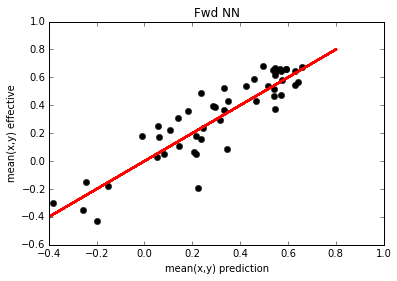

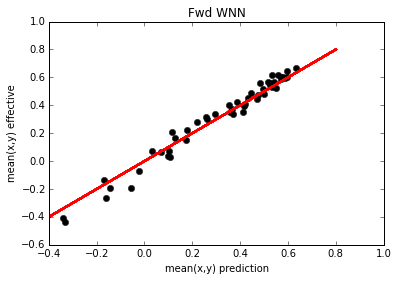

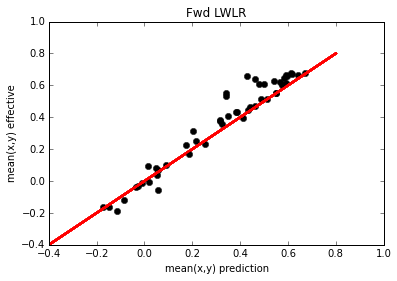

In [50]:
from explauto import Environment
environment = Environment.from_configuration('simple_arm', 'low_dimensional')

from explauto.sensorimotor_model import sensorimotor_models
print 'Available sensorimotor models: {}'.format(sensorimotor_models.keys())

from scipy import spatial
import numpy as np
import time

#Environment definition
from explauto.environment.environment import Environment
environment = Environment.from_configuration('simple_arm', 'mid_dimensional')

from explauto.sensorimotor_model import sensorimotor_models
from explauto import SensorimotorModel
from explauto.utils import rand_bounds

#################
# FORWARD MODELS#
#################

# ****
# *NN*
# ****

#Creation of the dataset
random_motors = environment.random_motors(n=1000)
    
sm_cls, sm_configs = sensorimotor_models['nearest_neighbor']
model = sm_cls(environment.conf, **sm_configs['default'])

for m in random_motors:
    s = environment.compute_sensori_effect(m)
    model.update(m, s)
    
    
#Test of the model
test = environment.random_motors(n=50)
distance = []
timer = []
pred_eff = []

for mTest in test :
    start = time.time()
    sTest_pred = model.forward_prediction(mTest)
    end = time.time()
    sTest_eff = environment.compute_sensori_effect(mTest)
    pred_eff.append([np.mean(sTest_pred),np.mean(sTest_eff)])
    distance.append(spatial.distance.pdist([sTest_pred,sTest_eff])[0])
    timer.append(end - start)
# Distance between the predictive and effectiv value
fwd_comparison = {}
fwd_comparison['NN'] = [np.mean(distance), np.std(distance) ,max(distance),
                    np.mean(timer), np.std(timer), max(timer)]
figure(1)
for i in pred_eff:
    plot(i[0], i[1], 'ok')
    plot([-0.4,0.8], [-0.4,0.8], 'r-', lw=2)
title("Fwd NN")
xlabel("mean(x,y) prediction")
ylabel("mean(x,y) effective")


# *****
# *WNN*
# *****

#Creation of the dataset
random_motors = environment.random_motors(n=10000)
    
sm_cls, sm_configs = sensorimotor_models['WNN']
model = sm_cls(environment.conf, **sm_configs['default'])

for m in random_motors:
    s = environment.compute_sensori_effect(m)
    model.update(m, s)
#Test of the model
test = environment.random_motors(n=50)
distance = []
timer = []
pred_eff = []

for mTest in test :
    start = time.time()
    sTest_pred = model.forward_prediction(mTest)
    end = time.time()
    sTest_eff = environment.compute_sensori_effect(mTest)    
    pred_eff.append([np.mean(sTest_pred),np.mean(sTest_eff)])
    distance.append(spatial.distance.pdist([sTest_pred,sTest_eff])[0])
    timer.append(end - start)

# Distance between the predictive and effectiv value
inv_comparison['WNN'] = [np.mean(distance), np.std(distance) ,max(distance),
                    np.mean(timer), np.std(timer), max(timer)]
figure(2)
for i in pred_eff:
    plot(i[0], i[1], 'ok')
    plot([-0.4,0.8], [-0.4,0.8], 'r-', lw=2)
title("Fwd WNN")
xlabel("mean(x,y) prediction")
ylabel("mean(x,y) effective")


#******
#*LWLR*
#******

#Creation of the dataset
random_motors = environment.random_motors(n=10000)
    
sm_cls, sm_configs = sensorimotor_models['LWLR-BFGS']
model = sm_cls(environment.conf, **sm_configs['default'])

for m in random_motors:
    s = environment.compute_sensori_effect(m)
    model.update(m, s)
    
#Test of the model
test = environment.random_motors(n=50)
distance = []
timer = []
pred_eff = []

for mTest in test :
    start = time.time()
    sTest_pred = model.forward_prediction(mTest)
    end = time.time()
    sTest_eff = environment.compute_sensori_effect(mTest)
    pred_eff.append([np.mean(sTest_pred),np.mean(sTest_eff)])
    distance.append(spatial.distance.pdist([sTest_pred,sTest_eff])[0])
    timer.append(end - start)
    
# Distance between the predictive and effectiv value
comparison['LWLR'] = [np.mean(distance), np.std(distance) ,max(distance),
                    np.mean(timer), np.std(timer), max(timer)]
figure(3)
for i in pred_eff:
    plot(i[0], i[1], 'ok')
    plot([-0.4,0.8], [-0.4,0.8], 'r-', lw=2)
title("Fwd LWLR")
xlabel("mean(x,y) prediction")
ylabel("mean(x,y) effective")

In [55]:
#################
# INVERSE MODELS#
#################

# ****
# *NN*
# ****

#Creation of the dataset
random_sensors = rand_bounds(np.array([[0.8,-0.1], [0.9,0.1]]), n=10000)
    
sm_cls, sm_configs = sensorimotor_models['nearest_neighbor']
model = sm_cls(environment.conf, **sm_configs['default'])

for m in random_sensors:
    s = environment.compute_sensori_effect(m)
    model.update(m, s)

#Test of the model
test_cases = rand_bounds(np.array([[0.8,-0.1], [0.9,0.1]]), n=50)
distance = []
timer = []
goal_eff = []

for s_g in test_cases :
    start = time.time()
    mTest = model.inverse_prediction(s_g)
    end = time.time()
    s_eff = environment.compute_sensori_effect(mTest)
    distance.append(spatial.distance.pdist([s_g,s_eff])[0])
    goal_eff.append([np.mean(s_g),np.mean(s_eff)])
    timer.append(end - start)
    
# Distance between the predictive and effectiv value
inv_comparison = {} #to remove after the first use
inv_comparison['NN'] = [np.mean(distance), np.std(distance) ,max(distance),
                    np.mean(timer), np.std(timer), max(timer)]
    
figure(1)
for i in goal_eff:
    plot(i[0], i[1], 'ok')
    plot([-0.4,0.8], [-0.4,0.8], 'r-', lw=2)
title("Inv NN")
xlabel("mean(x,y) goal")
ylabel("mean(x,y) eff")

# *****
# *wNN*
# *****

#Creation of the dataset
random_sensors = rand_bounds(np.array([[0.8,-0.1], [0.9,0.1]]), n=10000)
    
sm_cls, sm_configs = sensorimotor_models['WNN']
model = sm_cls(environment.conf, **sm_configs['default'])

for s in random_sensors:
    m = environment.compute_sensori_effect(m)
    model.update(m, s)

#Test of the model
test_cases = rand_bounds(np.array([[0.8,-0.1], [0.9,0.1]]), n=50)
distance = []
timer = []
goal_eff = []

for s_g in test_cases :
    start = time.time()
    mTest = model.inverse_prediction(s_g)
    end = time.time()
    s_eff = environment.compute_sensori_effect(mTest)
    distance.append(spatial.distance.pdist([s_g,s_eff])[0])
    goal_eff.append([np.mean(s_g),np.mean(s_eff)])
    timer.append(end - start)
    
# Distance between the predictive and effectiv value
inv_comparison = {} #to remove after the first use
inv_comparison['WNN'] = [np.mean(distance), np.std(distance) ,max(distance),
                    np.mean(timer), np.std(timer), max(timer)]

for m in random_motors:
    s = environment.compute_sensori_effect(m)
    model.update(m, s)
    
figure(1)
for i in goal_eff:
    plot(i[0], i[1], 'ok')
    plot([-0.4,0.8], [-0.4,0.8], 'r-', lw=2)
title("Inv NN")
xlabel("mean(x,y) goal")
ylabel("mean(x,y) eff")

ValueError: angles and lengths must be the same size!